In [1]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
def scoreCalculator(predictor, attributes, labels):
    predicted = predictor.predict(attributes)
    errorScore = 0
    for guessIndex in range(len(predicted)):
        guess = predicted[guessIndex]
        actual = labels[guessIndex]
        if guess == 'hold' :
            errorScore += 0
        elif guess == 'long':
            if actual == 'short':
                errorScore += -15
            elif actual == 'hold':
                errorScore += -5
            else :#actual == 'long'
                errorScore += 20
        else: #short
            if actual == 'long':
                errorScore += -20
            elif actual == 'hold':
                errorScore += 0
            else: #actual == short
                errorScore += 20
    myMatrix = plot_confusion_matrix(predictor, attributes, labels,
                                     cmap=plt.cm.Blues, normalize = 'all')    
    plt.show()
    return  errorScore/len(predicted)

In [2]:
from tabulate import tabulate
def catBoostMaker(sectorDF,zScoreAnswer,fiveDayChangeAnswer, tmmrwUpAnswer, sector, catLabels, count):
    catIndicies = []
    counter = -1
    for col in sectorDF.columns: #finding indices for cat variables
        counter += 1
        if col in catLabels:
            catIndicies.append(counter)
    masterList = sectorDF.values
    masterTrainList, masterTestList, zScoreTrainList, zScoreTestList, fiveDayChangeTrainList, fiveDayChangeTestList \
    tmmrwUpTrainList, tmmrwUpTestList = train_test_split(masterList, zScoreAnswer, fiveDayChangeAnswer,test_size = .25)
    
    answerTrainList = [zScoreTrainList,fiveDayChangeTrainList, tmmrwUpTrainList]
    answerTestList = [zScoreTestList,fiveDayChangeTestList, tmmrwUpTestList]
    trainPools = [Pool(data = masterTrainList, label = x, cat_features = catIndicies) for x in answerTrainList]
    testPools = [Pool(data = masterTestList, label = x, cat_features = catIndicies) for x in answerTestList]
    modelNames = ['ZScorePredictor','FiveDayPredictor','TmmrwUpPredictor']
    folderRoot = 'catPredictors/'
    accuracyList = []
    scoreList = []
    for name, train, test in zip(modelNames, trainPools, testPools):
        train.set_feature_names([x for x in sectorDF.columns])
        print(name)
        model = CatBoostClassifier(bootstrap_type = 'Bernoulli')
        model.fit(train, eval_set = test, logging_level = 'Silent')
        sector = sector.replace(' ', '_')
        model.save_model('{}{}-{}-{}.cbm'.format(folderRoot, name, sector, count))
        accuracy =  model.score(test)
        print('Accuracy: ', accuracy)
        error = scoreCalculator(model, test,test.get_label())
        print('Error Score:', error)
        accuracyList.append(accuracy)
        scoreList.append(error)
        
    averageAccuracy = sum([x for x in accuracyList])/len(accuracyList)
    averageScore = sum([x for x in scoreList])/len(scoreList)
    print('type of feat imp: ', type(CatBoostClassifier.get_feature_importance(model, prettified = True)))
    print(CatBoostClassifier.get_feature_importance(model, prettified = True))
    print('[1:] ver.')
    print(CatBoostClassifier.get_feature_importance(model, prettified = True)[1:])
    featureList = CatBoostClassifier.get_feature_importance(model, prettified = True)[1:]
    featureDF = pd.DataFrame(data = 
                             {'featureName': [featureList[x][1] for x in len(featureList)],
                            'importance': [featureList[x][1] for x in len(featureList)]}).set_index('featureName')
    return averageAccuracy, averageScore, featureDF

VolumeZScoreTenDay
highVsLowPerc
dayPercentChange
ticker
fiveVSTenDayWeightedAverage
fiveVsTenDaySlopeChange
fiveVsTenDayAverage
MACD
bPercent
rsi
slowVSFastKAMA
aroon
bop
MFI
WilliamsR
zScoreOfChangeTmmrw
percentChangeInFiveDays
typPrice
sector
industry
thisDayZScore
totalVolumeOfTheDay
vsMarketPerformance
titleSent
articleSent
titleSentChangeSinceYesterday
articleSentChangeSinceYesterday
titleSentbPercent
articleSentbPercent
DTWEXAFEGSValue
DTWEXAFEGSlastChangeP
DTWEXAFEGSfiveVsTenTickAverage
DTWEXAFEGSbPercent
DPRIMEValue
DPRIMElastChangeP
TOTCIValue
TOTCIlastChangeP
TOTCIfiveVsTenTickAverage
TOTCIbPercent
UNRATEValue
UNRATElastChangeP
UNRATEfiveVsTenTickAverage
UNRATEbPercent
CONSUMERValue
CONSUMERlastChangeP
CONSUMERfiveVsTenTickAverage
CONSUMERbPercent
BUSLOANSValue
BUSLOANSlastChangeP
BUSLOANSfiveVsTenTickAverage
BUSLOANSbPercent
CCLACBW027SBOGValue
CCLACBW027SBOGlastChangeP
CCLACBW027SBOGfiveVsTenTickAverage
CCLACBW027SBOGbPercent
STLFSI2Value
STLFSI2lastChangeP
STLFSI2fiveVsTe

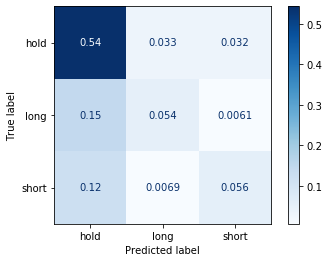

Error Score: 1.8180919100679105
Confusion matrix:
 [[0.54374629 0.03250478 0.03237291]
 [0.14577702 0.05426254 0.00613173]
 [0.122305   0.00685699 0.05604272]] 

FiveDayPredictor
Accuracy:  0.6046680292740819


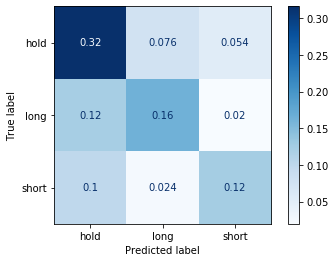

Error Score: 4.634733302564779
Confusion matrix:
 [[0.3163447  0.07562471 0.05399881]
 [0.12217314 0.16351289 0.01958199]
 [0.09982198 0.02413134 0.12481044]] 

-------------------------------------------


Sector is:  Basic Materials
ZScorePredictor
Accuracy:  0.551044173589007


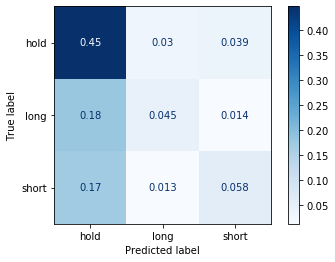

Error Score: 1.4463162797919416
Confusion matrix:
 [[0.44771369 0.03035479 0.0391274 ]
 [0.18080894 0.04533809 0.0135859 ]
 [0.1719587  0.0131201  0.05799239]] 

FiveDayPredictor
Accuracy:  0.5685117615091996


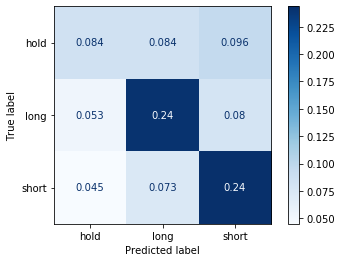

Error Score: 6.575964599021815
Confusion matrix:
 [[0.08399969 0.08446549 0.09595528]
 [0.05302383 0.24097508 0.07957457]
 [0.04510519 0.07336387 0.24353699]] 

-------------------------------------------


Sector is:  Healthcare
ZScorePredictor
Accuracy:  0.5646932281629543


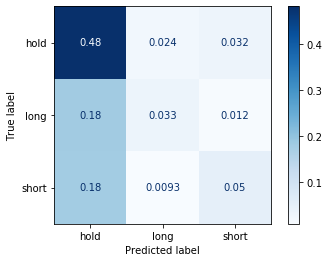

Error Score: 1.1733070407385828
Confusion matrix:
 [[0.48110967 0.02366334 0.03195447]
 [0.17951418 0.03345583 0.01201094]
 [0.17884193 0.00932192 0.05012773]] 

FiveDayPredictor
Accuracy:  0.570429794290324


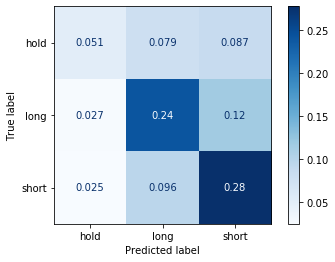

Error Score: 6.235490521220813
Confusion matrix:
 [[0.05064312 0.07910187 0.08674315]
 [0.02655403 0.24192175 0.1159862 ]
 [0.02485098 0.09633398 0.27786492]] 

-------------------------------------------


Sector is:  Consumer Cyclical
ZScorePredictor
Accuracy:  0.5758517681253028


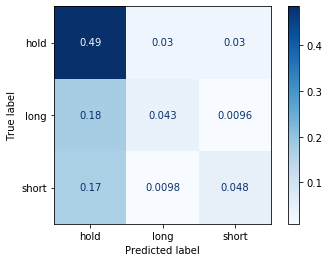

Error Score: 1.3258921362829001
Confusion matrix:
 [[0.48510415 0.0296706  0.02963023]
 [0.17673179 0.04287098 0.00964799]
 [0.16861779 0.00984983 0.04787663]] 

FiveDayPredictor
Accuracy:  0.5437187146778621


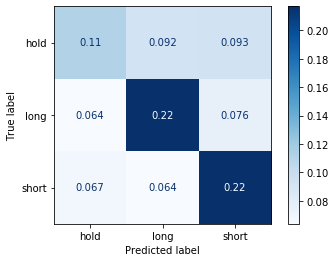

Error Score: 5.712296140804134
Confusion matrix:
 [[0.1110528  0.09220087 0.09296787]
 [0.06374132 0.21689811 0.07601324]
 [0.06737446 0.06398353 0.2157678 ]] 

-------------------------------------------


Sector is:  Financial Services
ZScorePredictor
Accuracy:  0.6416095511828432


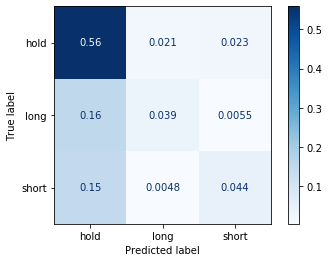

Error Score: 1.3794679047829612
Confusion matrix:
 [[0.5581841  0.02131329 0.0232589 ]
 [0.15544255 0.03895644 0.00549783]
 [0.14804333 0.00483455 0.04446901]] 

FiveDayPredictor
Accuracy:  0.6644999631513008


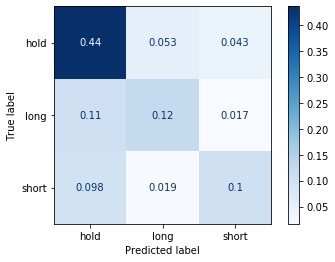

Error Score: 3.6771316972510872
Confusion matrix:
 [[0.43667183 0.05313582 0.04348147]
 [0.10537254 0.12331049 0.01662613]
 [0.09813546 0.01874862 0.10451765]] 

-------------------------------------------


Sector is:  Industrials
ZScorePredictor
Accuracy:  0.5795375795375796


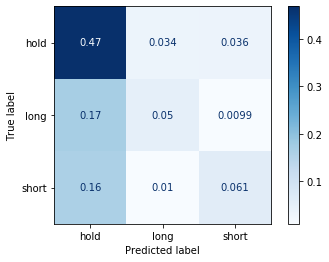

Error Score: 1.6895041895041896
Confusion matrix:
 [[0.46903547 0.03370503 0.03581554]
 [0.16874567 0.04973855 0.00992251]
 [0.16203616 0.01023751 0.06076356]] 

FiveDayPredictor
Accuracy:  0.563031563031563


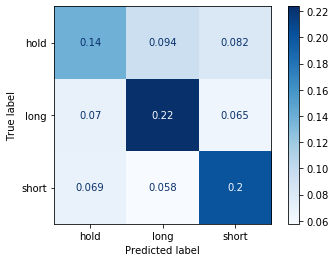

Error Score: 5.853493353493353
Confusion matrix:
 [[0.13894664 0.09399609 0.08161658]
 [0.07015057 0.22358722 0.06460656]
 [0.06885907 0.05773956 0.2004977 ]] 

-------------------------------------------


Sector is:  Technology
ZScorePredictor
Accuracy:  0.5700919184265146


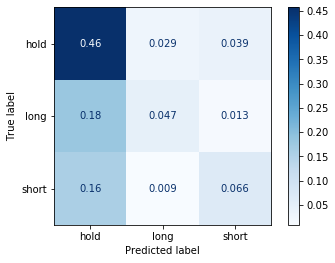

Error Score: 1.7212466642506508
Confusion matrix:
 [[0.4571871  0.02889335 0.03867822]
 [0.18146476 0.04727704 0.01284881]
 [0.15899582 0.00902711 0.06562778]] 

FiveDayPredictor
Accuracy:  0.5576713998616282


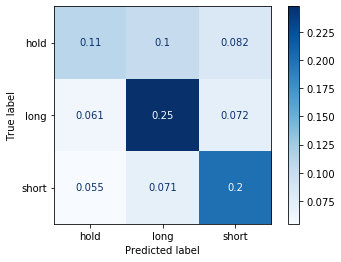

Error Score: 5.953612492999045
Confusion matrix:
 [[0.10974204 0.10157151 0.08193589]
 [0.06141073 0.24748789 0.071558  ]
 [0.05478865 0.07106382 0.20044147]] 

-------------------------------------------


Sector is:  Communication Services
ZScorePredictor
Accuracy:  0.5486532772847579


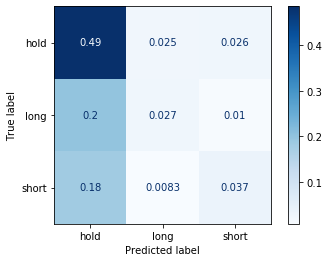

Error Score: 0.8103689864549276
Confusion matrix:
 [[0.48528725 0.02491048 0.02623385]
 [0.19834968 0.02677876 0.01043126]
 [0.18316986 0.0082516  0.03658726]] 

FiveDayPredictor
Accuracy:  0.5396232290207068


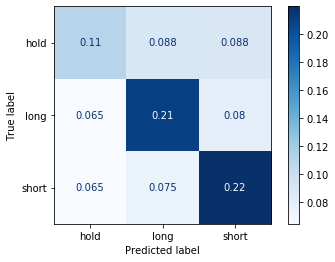

Error Score: 5.434765685816597
Confusion matrix:
 [[0.11015102 0.0884322  0.08796513]
 [0.06507862 0.20987078 0.07963568]
 [0.06461155 0.07465359 0.21960143]] 

-------------------------------------------


Sector is:  Energy
ZScorePredictor
Accuracy:  0.6026897097304205


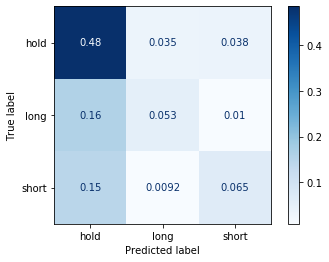

Error Score: 1.8408081299823527
Confusion matrix:
 [[0.48457372 0.03517313 0.0384592 ]
 [0.15827907 0.0528814  0.01034504]
 [0.14580417 0.00924968 0.06523459]] 

FiveDayPredictor
Accuracy:  0.5863810624961967


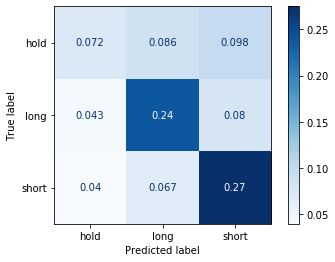

Error Score: 7.253696829550295
Confusion matrix:
 [[0.07198929 0.08641149 0.09773018]
 [0.04284063 0.23963975 0.0799002 ]
 [0.03979797 0.06693848 0.27475202]] 

-------------------------------------------


Sector is:  Consumer Defensive
ZScorePredictor
Accuracy:  0.5597021958345113


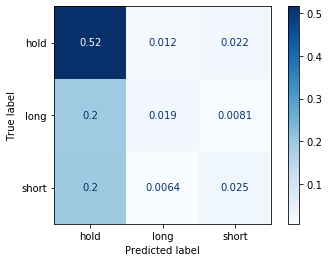

Error Score: 0.5503722552068608
Confusion matrix:
 [[0.51625671 0.01206295 0.0218641 ]
 [0.19545754 0.01884836 0.0081048 ]
 [0.19639996 0.00640844 0.02459712]] 

FiveDayPredictor
Accuracy:  0.5323720667232118


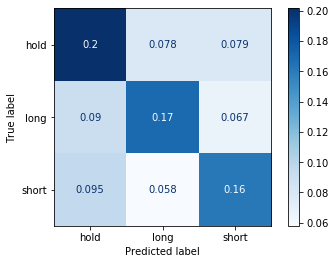

Error Score: 4.010460842521911
Confusion matrix:
 [[0.20148902 0.0784092  0.07850344]
 [0.09018943 0.16935256 0.06728866]
 [0.09527848 0.05795872 0.16153049]] 

-------------------------------------------


Sector is:  Utilities
ZScorePredictor
Accuracy:  0.6084953940634595


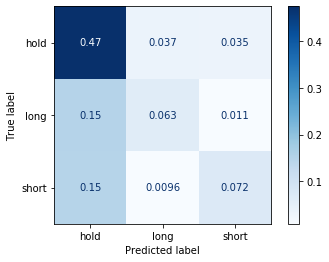

Error Score: 2.1485841009894235
Confusion matrix:
 [[0.47355851 0.03701808 0.03548277]
 [0.15063118 0.06328898 0.01108837]
 [0.14773115 0.00955305 0.0716479 ]] 

FiveDayPredictor
Accuracy:  0.5914363698396452


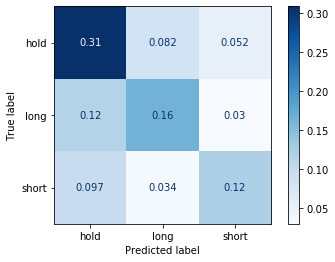

Error Score: 4.152166496076425
Confusion matrix:
 [[0.30859775 0.08154214 0.05151825]
 [0.115319   0.1625725  0.02951211]
 [0.09689526 0.03377687 0.12026612]] 

-------------------------------------------


Sector is:  Financial
ZScorePredictor
Accuracy:  0.7086956521739131


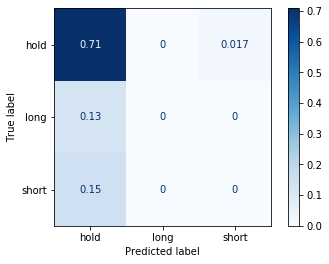

Error Score: 0.0
Confusion matrix:
 [[0.70869565 0.         0.0173913 ]
 [0.12608696 0.         0.        ]
 [0.14782609 0.         0.        ]] 

FiveDayPredictor
Accuracy:  0.7347826086956522


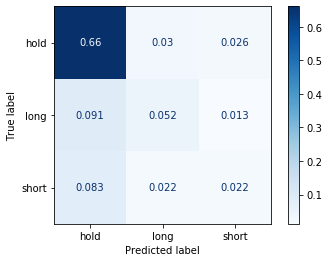

Error Score: 0.7391304347826086
Confusion matrix:
 [[0.66086957 0.03043478 0.02608696]
 [0.09130435 0.05217391 0.01304348]
 [0.0826087  0.02173913 0.02173913]] 

-------------------------------------------


Catboost accuracy:  0.5925934404162094
Catboost score:  3.1723709164231484
-------------------------------------------


Sector is:  Industrials
ZScorePredictor
Accuracy:  0.5813232035454258


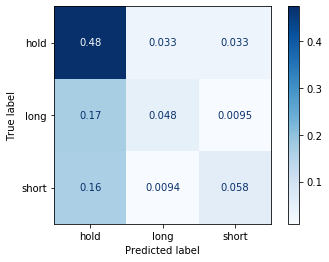

Error Score: 1.631054131054131
Confusion matrix:
 [[0.47511871 0.03254194 0.0328585 ]
 [0.1694207  0.04827477 0.00946502]
 [0.16498892 0.00940171 0.05792972]] 

FiveDayPredictor
Accuracy:  0.567426400759734


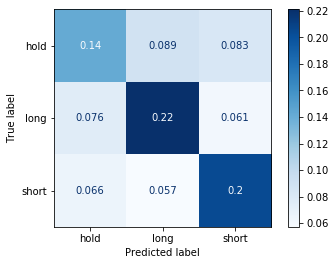

Error Score: 5.973884140550807
Confusion matrix:
 [[0.14213359 0.08914213 0.08277936]
 [0.0759101  0.22117759 0.06141184]
 [0.06612852 0.05720165 0.20411523]] 

-------------------------------------------


Sector is:  Technology
ZScorePredictor
Accuracy:  0.570418366004473


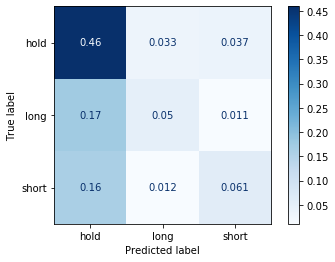

Error Score: 1.6731351138008157
Confusion matrix:
 [[0.45895277 0.03279174 0.0373635 ]
 [0.17395737 0.050421   0.01095251]
 [0.16297198 0.01154453 0.0610446 ]] 

FiveDayPredictor
Accuracy:  0.556966188659387


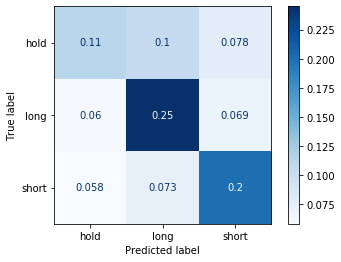

Error Score: 5.890178923825812
Confusion matrix:
 [[0.11209051 0.10492041 0.07775293]
 [0.05976187 0.24500066 0.06910275]
 [0.05811735 0.0733785  0.19987502]] 

-------------------------------------------


Sector is:  Financial Services
ZScorePredictor
Accuracy:  0.6403137139925237


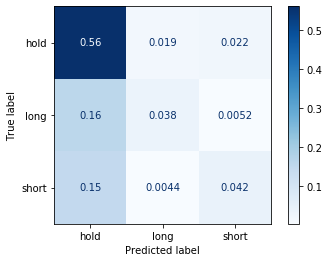

Error Score: 1.3384886022135893
Confusion matrix:
 [[0.56006743 0.01946786 0.02182804]
 [0.15927582 0.03783625 0.00518947]
 [0.14957121 0.00435388 0.04241003]] 

FiveDayPredictor
Accuracy:  0.6681228468811845


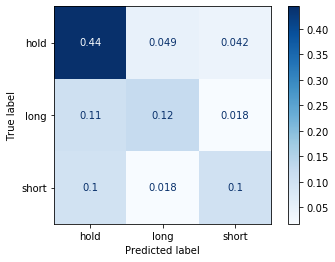

Error Score: 3.6126951550245545
Confusion matrix:
 [[0.44370007 0.04924137 0.04179433]
 [0.10532874 0.12255369 0.01825112]
 [0.09962618 0.01763542 0.10186909]] 

-------------------------------------------


Sector is:  Basic Materials
ZScorePredictor
Accuracy:  0.5554955649826456


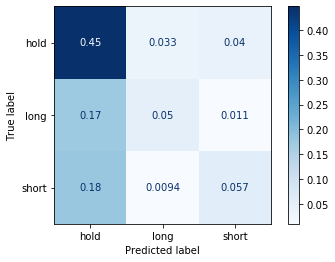

Error Score: 1.6197454685692247
Confusion matrix:
 [[0.4484381  0.03316622 0.03956807]
 [0.17300424 0.05013498 0.01072117]
 [0.17863479 0.00940995 0.05692248]] 

FiveDayPredictor
Accuracy:  0.5784033937524103


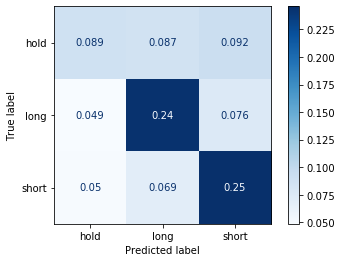

Error Score: 6.813729271114539
Confusion matrix:
 [[0.08870035 0.08661782 0.09201697]
 [0.04866949 0.24381026 0.07558812]
 [0.04967219 0.06903201 0.24589279]] 

-------------------------------------------


Sector is:  Real Estate
ZScorePredictor
Accuracy:  0.6588125665601704


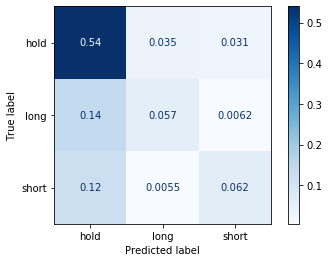

Error Score: 1.9988019169329074
Confusion matrix:
 [[0.53980298 0.03494409 0.03115016]
 [0.1423722  0.05744143 0.0061901 ]
 [0.12100639 0.00552449 0.06156816]] 

FiveDayPredictor
Accuracy:  0.6048988285410011


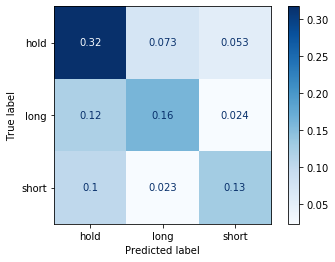

Error Score: 4.573016506922258
Confusion matrix:
 [[0.31662673 0.07328275 0.05304846]
 [0.1184771  0.16054313 0.02402822]
 [0.10323482 0.02302982 0.12772897]] 

-------------------------------------------


Sector is:  Healthcare
ZScorePredictor
Accuracy:  0.5612606550022432


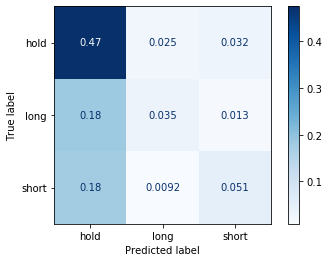

Error Score: 1.2008748317631224
Confusion matrix:
 [[0.47492149 0.02487663 0.03218932]
 [0.18369224 0.03485868 0.0132122 ]
 [0.17561687 0.00915209 0.05148048]] 

FiveDayPredictor
Accuracy:  0.5685733512786003


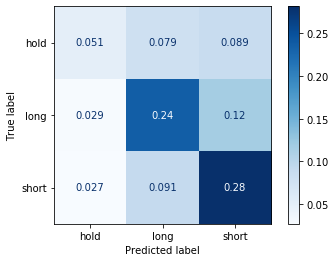

Error Score: 6.244279946164199
Confusion matrix:
 [[0.05121131 0.07927322 0.08860476]
 [0.02857784 0.23589053 0.11736205]
 [0.0269852  0.0906236  0.28147151]] 

-------------------------------------------


Sector is:  Consumer Cyclical
ZScorePredictor
Accuracy:  0.569499858944908


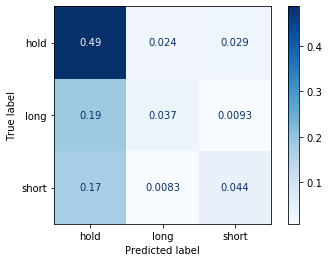

Error Score: 1.2074315882803368
Confusion matrix:
 [[0.4876476  0.02405997 0.02889614]
 [0.18675694 0.03739975 0.00926933]
 [0.17325595 0.0082618  0.0444525 ]] 

FiveDayPredictor
Accuracy:  0.5473340587595212


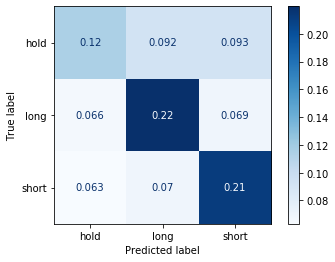

Error Score: 5.751017611735784
Confusion matrix:
 [[0.11506065 0.09225003 0.09253214]
 [0.06565107 0.21984444 0.06939911]
 [0.06315238 0.06968122 0.21242897]] 

-------------------------------------------


Sector is:  Consumer Defensive
ZScorePredictor
Accuracy:  0.5660930408472012


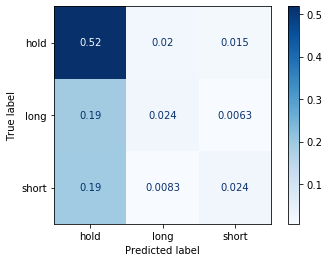

Error Score: 0.607034795763994
Confusion matrix:
 [[0.51815431 0.02004539 0.01512859]
 [0.19156581 0.0241112  0.0063351 ]
 [0.19251135 0.00832073 0.02382753]] 

FiveDayPredictor
Accuracy:  0.520518154311649


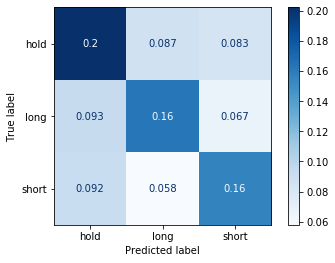

Error Score: 3.7140695915279878
Confusion matrix:
 [[0.20225038 0.08670575 0.08282905]
 [0.09294629 0.16272693 0.06741679]
 [0.09162254 0.05796142 0.15554085]] 

-------------------------------------------


Sector is:  Communication Services
ZScorePredictor
Accuracy:  0.5497246262785208


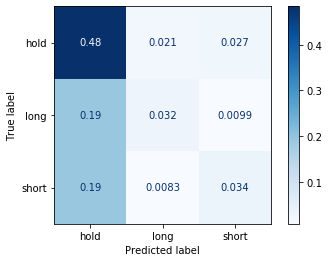

Error Score: 0.8843430369787569
Confusion matrix:
 [[0.48402832 0.02124312 0.02690795]
 [0.19189614 0.03154996 0.00991345]
 [0.19197482 0.00833989 0.03414634]] 

FiveDayPredictor
Accuracy:  0.5420928402832416


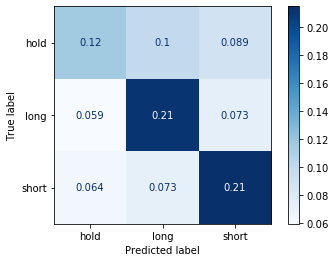

Error Score: 5.476003147128245
Confusion matrix:
 [[0.11542093 0.09976397 0.08867034]
 [0.05948072 0.21203777 0.07340677]
 [0.0638867  0.07269866 0.21463415]] 

-------------------------------------------


Sector is:  Energy
ZScorePredictor
Accuracy:  0.5928063673370193


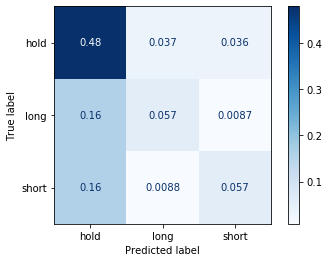

Error Score: 1.777750774652166
Confusion matrix:
 [[0.47937299 0.036758   0.03596816]
 [0.15857586 0.05662555 0.00874901]
 [0.15833283 0.00880977 0.05680783]] 

FiveDayPredictor
Accuracy:  0.5878242906616441


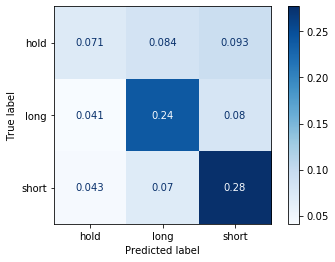

Error Score: 7.260465398869919
Confusion matrix:
 [[0.07102497 0.08427    0.0933228 ]
 [0.041011   0.23950422 0.0798955 ]
 [0.04325901 0.0704174  0.2772951 ]] 

-------------------------------------------


Sector is:  Utilities
ZScorePredictor
Accuracy:  0.6046591889559966


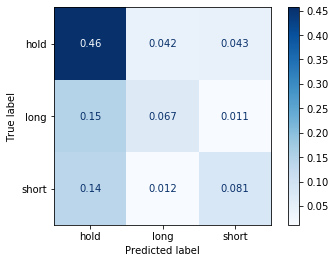

Error Score: 2.3339085418464194
Confusion matrix:
 [[0.45677308 0.0419327  0.0433132 ]
 [0.14874892 0.06712683 0.01138913]
 [0.13753236 0.0124245  0.08075928]] 

FiveDayPredictor
Accuracy:  0.5998274374460743


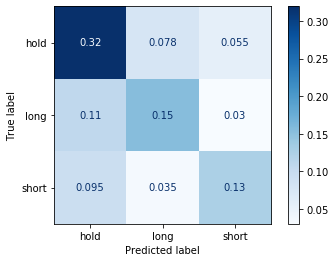

Error Score: 4.093183779119931
Confusion matrix:
 [[0.31958585 0.07799827 0.05539258]
 [0.10716135 0.15478861 0.03019845]
 [0.0949094  0.03451251 0.12545298]] 

-------------------------------------------


Sector is:  Financial
ZScorePredictor
Accuracy:  0.7066115702479339


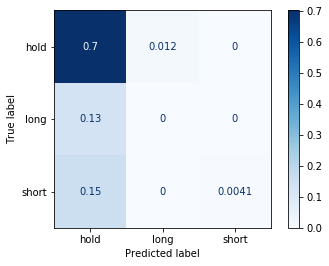

Error Score: 0.02066115702479339
Confusion matrix:
 [[0.70247934 0.01239669 0.        ]
 [0.12809917 0.         0.        ]
 [0.15289256 0.         0.00413223]] 

FiveDayPredictor
Accuracy:  0.71900826446281


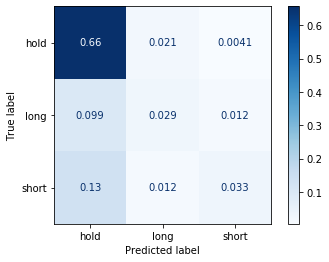

Error Score: 0.7024793388429752
Confusion matrix:
 [[0.65702479 0.02066116 0.00413223]
 [0.09917355 0.02892562 0.01239669]
 [0.1322314  0.01239669 0.03305785]] 

-------------------------------------------


Catboost accuracy:  0.5924172824373466
Catboost score:  3.183259698737803
-------------------------------------------


Sector is:  Industrials
ZScorePredictor
Accuracy:  0.581374806776239


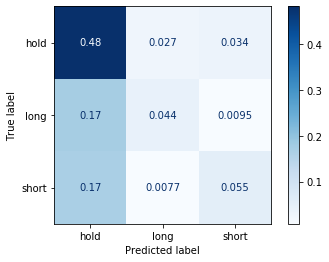

Error Score: 1.527492980851131
Confusion matrix:
 [[0.48310672 0.02653081 0.03394429]
 [0.17325468 0.04375532 0.00946402]
 [0.16770245 0.00772895 0.05451276]] 

FiveDayPredictor
Accuracy:  0.5660430928420455


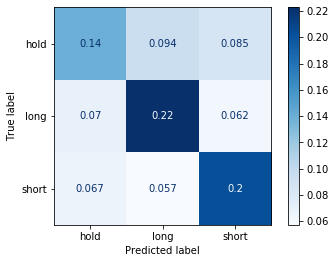

Error Score: 5.953184643048677
Confusion matrix:
 [[0.13987823 0.09356762 0.08454525]
 [0.06952901 0.22278305 0.06214707]
 [0.06687908 0.05728887 0.20338181]] 

-------------------------------------------


Sector is:  Financial Services
ZScorePredictor
Accuracy:  0.6441090269636577


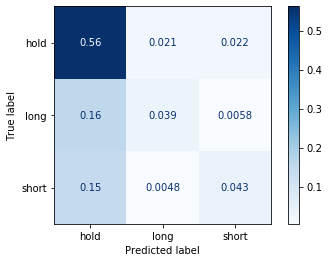

Error Score: 1.3511869871043376
Confusion matrix:
 [[0.56194314 0.02110199 0.02246483]
 [0.15558324 0.0389068  0.00575909]
 [0.14621923 0.0047626  0.04325909]] 

FiveDayPredictor
Accuracy:  0.666588511137163


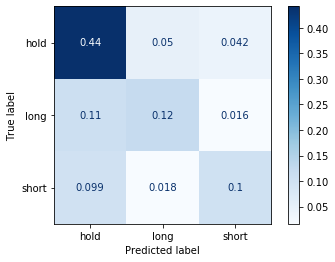

Error Score: 3.6459554513481827
Confusion matrix:
 [[0.44223329 0.05042497 0.04163247]
 [0.10805979 0.12180539 0.0162075 ]
 [0.09942849 0.01765826 0.10254982]] 

-------------------------------------------


Sector is:  Real Estate
ZScorePredictor
Accuracy:  0.6526127083195007


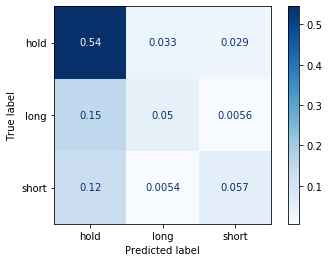

Error Score: 1.7927096474337694
Confusion matrix:
 [[0.54498373 0.03333112 0.02914813]
 [0.14912688 0.05026227 0.00557732]
 [0.12475931 0.00544453 0.05736671]] 

FiveDayPredictor
Accuracy:  0.6011553017727906


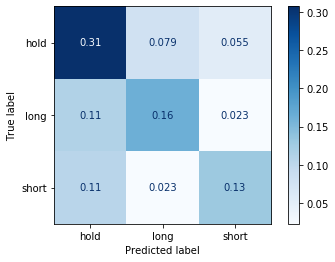

Error Score: 4.6793041630701815
Confusion matrix:
 [[0.30715092 0.0792776  0.05484364]
 [0.11267512 0.16360135 0.02284045]
 [0.10603546 0.02317243 0.13040303]] 

-------------------------------------------


Sector is:  Consumer Defensive
ZScorePredictor
Accuracy:  0.5596216319510797


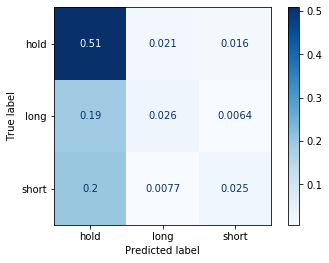

Error Score: 0.6774316835467227
Confusion matrix:
 [[0.50821708 0.02130709 0.01633862]
 [0.18975731 0.02627556 0.00640168]
 [0.19883432 0.00773935 0.02512899]] 

FiveDayPredictor
Accuracy:  0.5250334416204854


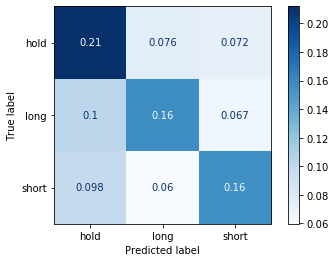

Error Score: 3.6532581693101474
Confusion matrix:
 [[0.21192433 0.07624689 0.07213835]
 [0.10242691 0.15727116 0.0665966 ]
 [0.09784063 0.05971718 0.15583795]] 

-------------------------------------------


Sector is:  Basic Materials
ZScorePredictor
Accuracy:  0.5590130441615591


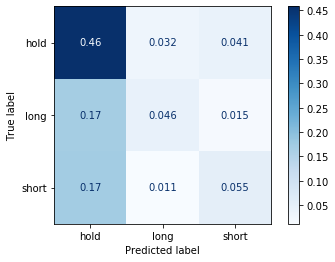

Error Score: 1.377101995913877
Confusion matrix:
 [[0.45843156 0.03206035 0.0413327 ]
 [0.16980984 0.04581172 0.0151658 ]
 [0.17122427 0.011394   0.05476976]] 

FiveDayPredictor
Accuracy:  0.5807795065220808


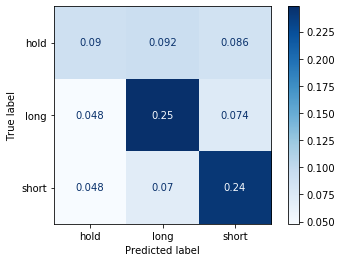

Error Score: 6.817146000314317
Confusion matrix:
 [[0.08997328 0.09193777 0.08643722]
 [0.04824768 0.24815339 0.07410027]
 [0.04801194 0.07048562 0.24265284]] 

-------------------------------------------


Sector is:  Energy
ZScorePredictor
Accuracy:  0.5949698556726143


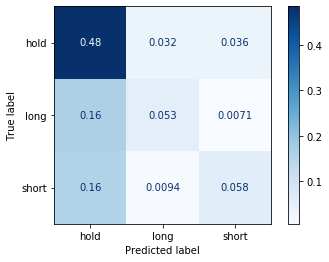

Error Score: 1.768771694781073
Confusion matrix:
 [[0.48444066 0.03154497 0.03641678]
 [0.16357104 0.05279825 0.00712502]
 [0.1569332  0.00943913 0.05773095]] 

FiveDayPredictor
Accuracy:  0.585957006272456


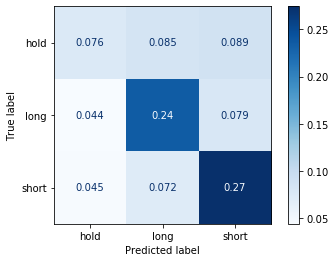

Error Score: 7.105535594665367
Confusion matrix:
 [[0.07630473 0.08519579 0.08854516]
 [0.04390719 0.23512575 0.07904513]
 [0.04530784 0.0720419  0.27452652]] 

-------------------------------------------


Sector is:  Communication Services
ZScorePredictor
Accuracy:  0.5533705655628097


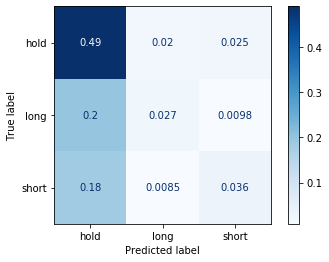

Error Score: 0.8361519704239755
Confusion matrix:
 [[0.49044285 0.01997955 0.02509243]
 [0.19893023 0.02721624 0.0097538 ]
 [0.1843782  0.00849524 0.03571148]] 

FiveDayPredictor
Accuracy:  0.5383465743726894


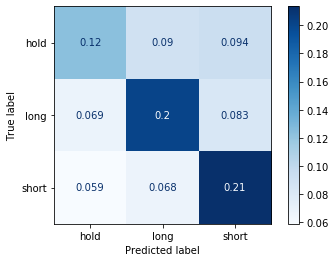

Error Score: 5.16479194525289
Confusion matrix:
 [[0.12396759 0.08975065 0.09376229]
 [0.06851255 0.20089672 0.08290726]
 [0.05899473 0.06772595 0.21348226]] 

-------------------------------------------


Sector is:  Healthcare
ZScorePredictor
Accuracy:  0.5638416566251617


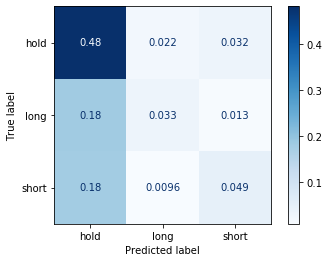

Error Score: 1.1343553353862632
Confusion matrix:
 [[0.48114429 0.02226983 0.03173116]
 [0.18152809 0.03344937 0.01323247]
 [0.17782389 0.0095729  0.049248  ]] 

FiveDayPredictor
Accuracy:  0.5631275940554291


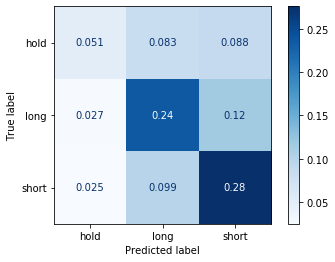

Error Score: 6.0360601597715
Confusion matrix:
 [[0.0509439  0.08280894 0.08809747]
 [0.0265542  0.23642165 0.11538805]
 [0.02496988 0.09905387 0.27576204]] 

-------------------------------------------


Sector is:  Technology
ZScorePredictor
Accuracy:  0.5704127987359273


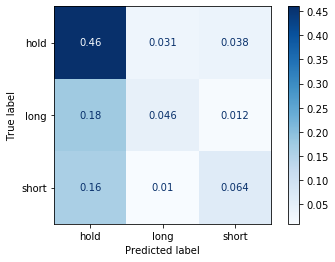

Error Score: 1.6709460793995654
Confusion matrix:
 [[0.45964185 0.03077885 0.0379551 ]
 [0.17608137 0.04638225 0.01204819]
 [0.16274936 0.00997432 0.0643887 ]] 

FiveDayPredictor
Accuracy:  0.5626440186977418


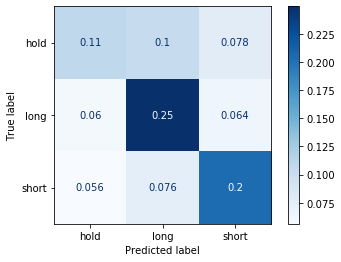

Error Score: 6.142274014089144
Confusion matrix:
 [[0.10863125 0.10369346 0.07758904]
 [0.05991178 0.24925933 0.06428995]
 [0.05629074 0.07558101 0.20475344]] 

-------------------------------------------


Sector is:  Consumer Cyclical
ZScorePredictor
Accuracy:  0.5714976234592766


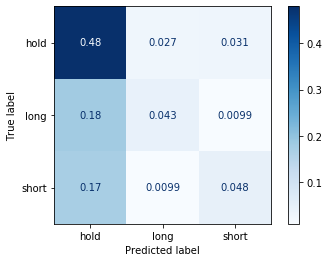

Error Score: 1.3453637315717393
Confusion matrix:
 [[0.48002095 0.02731008 0.03065335]
 [0.17973093 0.0430597  0.00994925]
 [0.17094981 0.00990897 0.04841698]] 

FiveDayPredictor
Accuracy:  0.5447514702328204


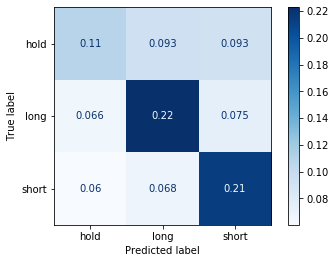

Error Score: 5.741158462901796
Confusion matrix:
 [[0.10843471 0.09336985 0.09252397]
 [0.06610006 0.22266978 0.07492145]
 [0.06033997 0.06799323 0.21364698]] 

-------------------------------------------


Sector is:  Utilities
ZScorePredictor
Accuracy:  0.6142237640936687


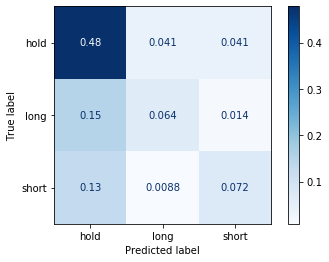

Error Score: 2.1127493495229834
Confusion matrix:
 [[0.47805724 0.04145707 0.04145707]
 [0.15160451 0.06383348 0.01352992]
 [0.12888118 0.00884649 0.07233304]] 

FiveDayPredictor
Accuracy:  0.6029488291413704


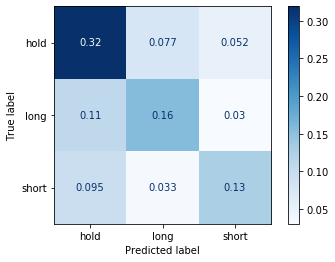

Error Score: 4.181266261925412
Confusion matrix:
 [[0.31916739 0.07701648 0.05238508]
 [0.1085863  0.15646141 0.03035559]
 [0.09522984 0.03347788 0.12732003]] 

-------------------------------------------


Sector is:  Financial
ZScorePredictor
Accuracy:  0.6870229007633588


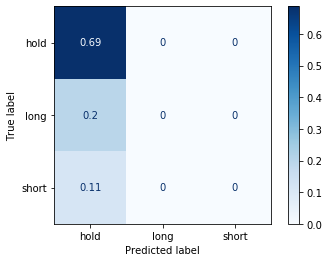

Error Score: 0.0
Confusion matrix:
 [[0.6870229  0.         0.        ]
 [0.19847328 0.         0.        ]
 [0.11450382 0.         0.        ]] 

FiveDayPredictor
Accuracy:  0.6984732824427481


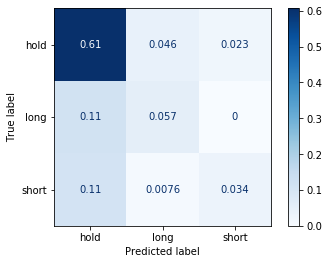

Error Score: 1.4885496183206106
Confusion matrix:
 [[0.60687023 0.04580153 0.02290076]
 [0.11450382 0.05725191 0.        ]
 [0.11068702 0.00763359 0.03435115]] 

-------------------------------------------


Catboost accuracy:  0.591163292174778
Catboost score:  3.175114414164736
-------------------------------------------


Sector is:  Basic Materials
ZScorePredictor
Accuracy:  0.5564895503971621


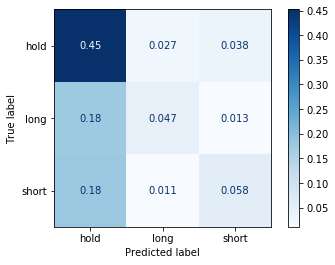

Error Score: 1.523097092619727
Confusion matrix:
 [[0.45245624 0.02714583 0.03809671]
 [0.17567672 0.04650266 0.01264749]
 [0.17868435 0.01125935 0.05753065]] 

FiveDayPredictor
Accuracy:  0.579933677797486


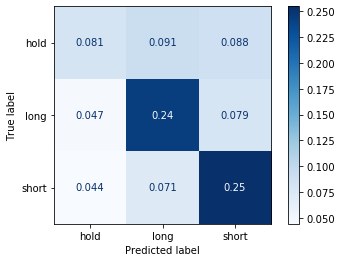

Error Score: 6.880542916634534
Confusion matrix:
 [[0.0810519  0.09138583 0.08822395]
 [0.04657978 0.24408113 0.07896969]
 [0.0441891  0.07071798 0.25480065]] 

-------------------------------------------


Sector is:  Industrials
ZScorePredictor
Accuracy:  0.5839715105102266


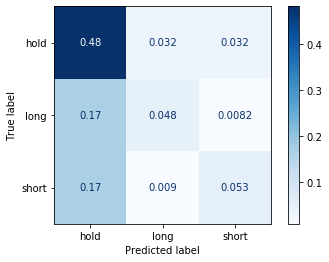

Error Score: 1.5617219753553306
Confusion matrix:
 [[0.48287164 0.03223977 0.03220825]
 [0.16702909 0.04840692 0.00819388]
 [0.16734424 0.00901327 0.05269295]] 

FiveDayPredictor
Accuracy:  0.5665122435473197


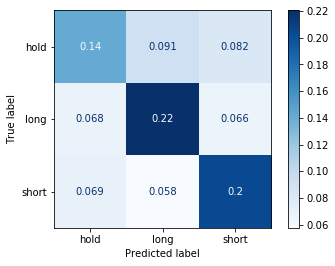

Error Score: 5.847908984904352
Confusion matrix:
 [[0.1419117  0.09114116 0.08156062]
 [0.06788314 0.22054143 0.06621285]
 [0.06908071 0.05760928 0.20405912]] 

-------------------------------------------


Sector is:  Financial Services
ZScorePredictor
Accuracy:  0.640210010705853


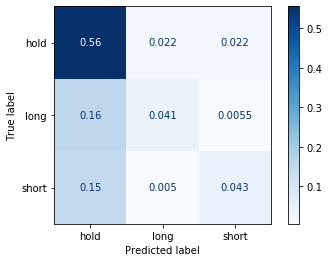

Error Score: 1.3897810433073754
Confusion matrix:
 [[0.55601508 0.02195433 0.02167569]
 [0.15727338 0.0408289  0.00549958]
 [0.14843005 0.00495696 0.04336604]] 

FiveDayPredictor
Accuracy:  0.6677372519688504


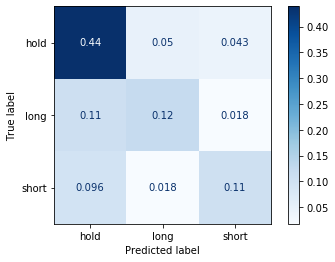

Error Score: 3.693885931335885
Confusion matrix:
 [[0.43914529 0.05014152 0.04302873]
 [0.10763049 0.12201739 0.0179653 ]
 [0.09563407 0.01786264 0.10657457]] 

-------------------------------------------


Sector is:  Communication Services
ZScorePredictor
Accuracy:  0.5601521266687364


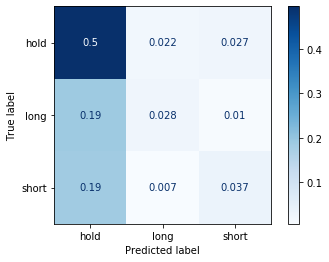

Error Score: 0.8716237193418193
Confusion matrix:
 [[0.49534306 0.02204284 0.0267774 ]
 [0.18852841 0.02770879 0.01047811]
 [0.1850357  0.00698541 0.03710028]] 

FiveDayPredictor
Accuracy:  0.527864017385905


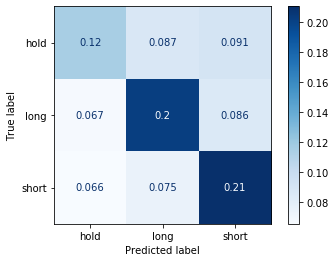

Error Score: 4.9677895063644835
Confusion matrix:
 [[0.11533685 0.08739522 0.09088792]
 [0.0669823  0.20218876 0.08599814]
 [0.06581807 0.07505433 0.2103384 ]] 

-------------------------------------------


Sector is:  Real Estate
ZScorePredictor
Accuracy:  0.6521337032633109


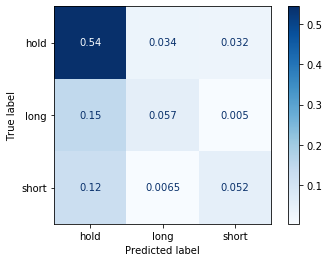

Error Score: 1.8136477738142422
Confusion matrix:
 [[0.54300436 0.03408641 0.0318404 ]
 [0.14671687 0.05681068 0.00502048]
 [0.12366231 0.00653983 0.05231867]] 

FiveDayPredictor
Accuracy:  0.6047033954287224


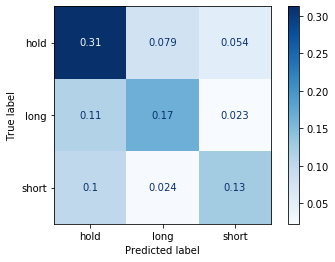

Error Score: 4.632712379442463
Confusion matrix:
 [[0.31259083 0.07920465 0.05390408]
 [0.114348   0.16567578 0.02259215]
 [0.10113621 0.02411151 0.12643678]] 

-------------------------------------------


Sector is:  Healthcare
ZScorePredictor
Accuracy:  0.5618101297124745


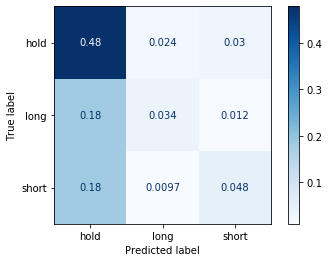

Error Score: 1.1524627385742867
Confusion matrix:
 [[0.47921678 0.0235146  0.03041611]
 [0.1812153  0.0342378  0.01182474]
 [0.18153002 0.00968909 0.04835555]] 

FiveDayPredictor
Accuracy:  0.5699480700492323


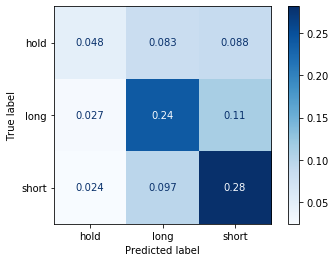

Error Score: 6.329609064136862
Confusion matrix:
 [[0.04822067 0.08275071 0.08780883]
 [0.02652699 0.24002428 0.11190792]
 [0.02418902 0.09686847 0.28170312]] 

-------------------------------------------


Sector is:  Technology
ZScorePredictor
Accuracy:  0.5735780423280423


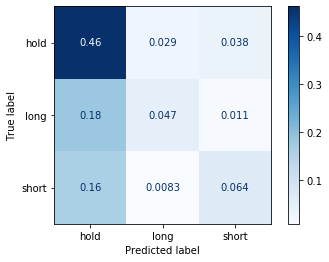

Error Score: 1.7273478835978835
Confusion matrix:
 [[0.46233466 0.02919974 0.03769841]
 [0.18032407 0.04742063 0.01137566]
 [0.15955688 0.0082672  0.06382275]] 

FiveDayPredictor
Accuracy:  0.5671296296296297


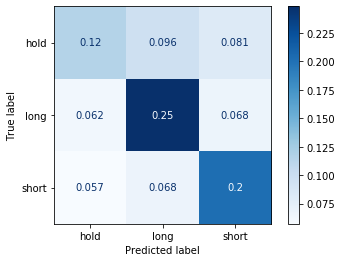

Error Score: 6.165674603174603
Confusion matrix:
 [[0.11603836 0.09636243 0.08115079]
 [0.06243386 0.24847884 0.06752646]
 [0.05714286 0.06825397 0.20261243]] 

-------------------------------------------


Sector is:  Energy
ZScorePredictor
Accuracy:  0.5937212582009933


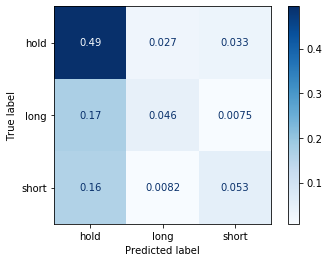

Error Score: 1.5715249248880987
Confusion matrix:
 [[0.49469618 0.02740818 0.03304924]
 [0.16959961 0.04623214 0.00748053]
 [0.16058618 0.00815501 0.05279294]] 

FiveDayPredictor
Accuracy:  0.589061254522043


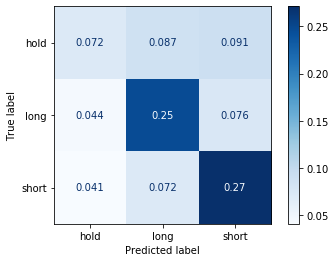

Error Score: 7.313139984057882
Confusion matrix:
 [[0.07173953 0.08706849 0.09062481]
 [0.0441474  0.24630572 0.07590901]
 [0.04120424 0.07198479 0.271016  ]] 

-------------------------------------------


Sector is:  Consumer Cyclical
ZScorePredictor
Accuracy:  0.5767745050700145


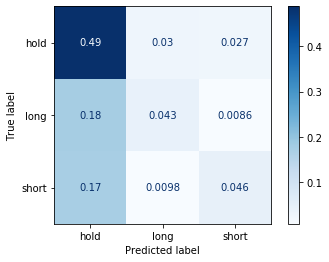

Error Score: 1.309954933204571
Confusion matrix:
 [[0.4878883  0.02977628 0.02687912]
 [0.1766055  0.04281346 0.00861098]
 [0.17157573 0.00977789 0.04607275]] 

FiveDayPredictor
Accuracy:  0.5463946563656848


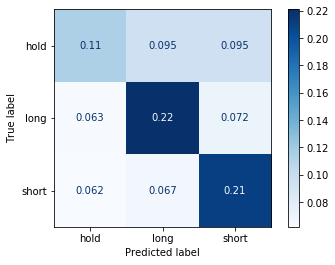

Error Score: 5.743602124577499
Confusion matrix:
 [[0.1138339  0.09548527 0.09484146]
 [0.06313375 0.22106873 0.0715033 ]
 [0.06196684 0.06667471 0.21149203]] 

-------------------------------------------


Sector is:  Utilities
ZScorePredictor
Accuracy:  0.6112348004795342


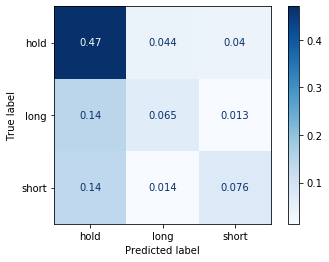

Error Score: 2.1313581092652853
Confusion matrix:
 [[0.47011475 0.04367186 0.04007536]
 [0.14283268 0.06542216 0.01335845]
 [0.13512588 0.01370098 0.07569789]] 

FiveDayPredictor
Accuracy:  0.6127761603014215


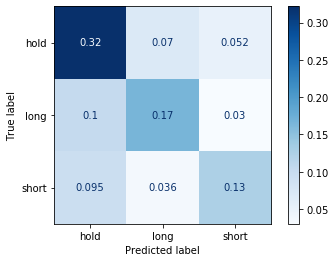

Error Score: 4.33036478849118
Confusion matrix:
 [[0.32180168 0.07038877 0.05223497]
 [0.10378489 0.16595307 0.03014215]
 [0.09505052 0.03562254 0.12502141]] 

-------------------------------------------


Sector is:  Consumer Defensive
ZScorePredictor
Accuracy:  0.5644592663172939


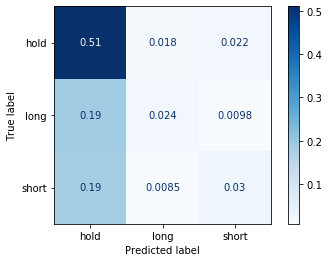

Error Score: 0.672224868985231
Confusion matrix:
 [[0.51024297 0.01772273 0.02181991]
 [0.19142449 0.02401143 0.0098142 ]
 [0.18627918 0.00848023 0.03020486]] 

FiveDayPredictor
Accuracy:  0.5256788947117675


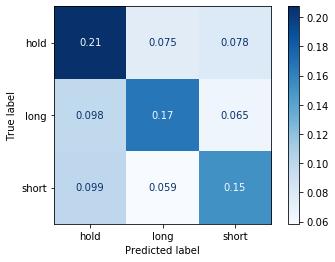

Error Score: 3.8132444020962364
Confusion matrix:
 [[0.20743211 0.07527394 0.07841829]
 [0.09776084 0.1665555  0.06488804]
 [0.09947594 0.05850405 0.15169128]] 

-------------------------------------------


Sector is:  Financial
ZScorePredictor
Accuracy:  0.6518218623481782


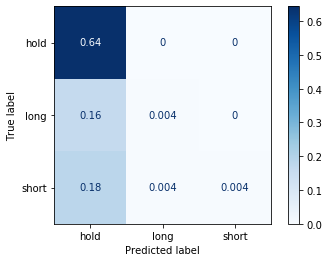

Error Score: 0.10121457489878542
Confusion matrix:
 [[0.6437247  0.         0.        ]
 [0.16194332 0.00404858 0.        ]
 [0.18218623 0.00404858 0.00404858]] 

FiveDayPredictor
Accuracy:  0.6720647773279352


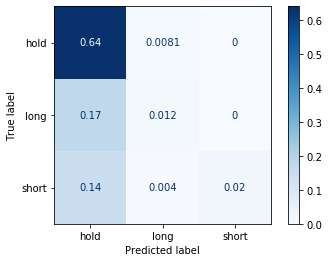

Error Score: 0.5465587044534413
Confusion matrix:
 [[0.63967611 0.00809717 0.        ]
 [0.17408907 0.01214575 0.        ]
 [0.1417004  0.00404858 0.02024291]] 

-------------------------------------------


Catboost accuracy:  0.5898400331265757
Catboost score:  3.170458042813419
-------------------------------------------


Sector is:  Industrials
ZScorePredictor
Accuracy:  0.586640358972727


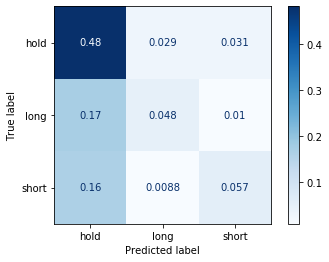

Error Score: 1.6061483626642905
Confusion matrix:
 [[0.48203545 0.02921427 0.03074181]
 [0.17105305 0.04792668 0.01040639]
 [0.16316074 0.00878338 0.05667823]] 

FiveDayPredictor
Accuracy:  0.5628997867803838


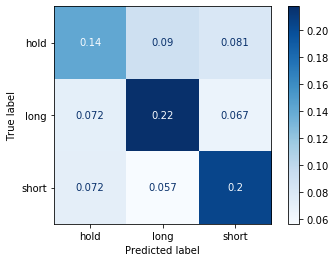

Error Score: 5.795913821086465
Confusion matrix:
 [[0.14167966 0.08952041 0.08083251]
 [0.0716036  0.21729307 0.06660726]
 [0.07195366 0.05658276 0.20392706]] 

-------------------------------------------


Sector is:  Healthcare
ZScorePredictor
Accuracy:  0.561139965971165


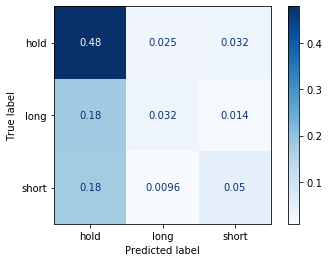

Error Score: 1.1091833079609563
Confusion matrix:
 [[0.47853049 0.02507388 0.03183487]
 [0.18106922 0.03246172 0.0136787 ]
 [0.17759918 0.00960419 0.05014776]] 

FiveDayPredictor
Accuracy:  0.5644980746843378


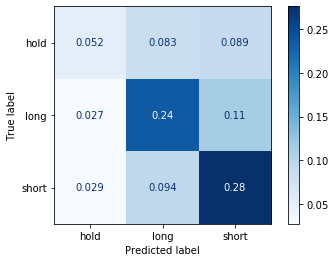

Error Score: 6.1410853407360975
Confusion matrix:
 [[0.05216262 0.08290051 0.08894511]
 [0.02690964 0.23582878 0.11375034]
 [0.0285887  0.09440763 0.27650667]] 

-------------------------------------------


Sector is:  Communication Services
ZScorePredictor
Accuracy:  0.5424882629107981


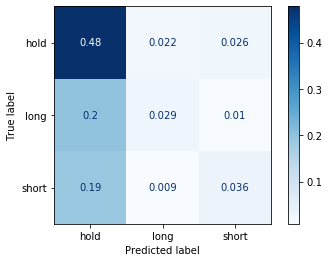

Error Score: 0.8333333333333334
Confusion matrix:
 [[0.47816901 0.02198748 0.02636933]
 [0.19804382 0.02879499 0.01040689]
 [0.19170579 0.00899844 0.03552426]] 

FiveDayPredictor
Accuracy:  0.5419405320813772


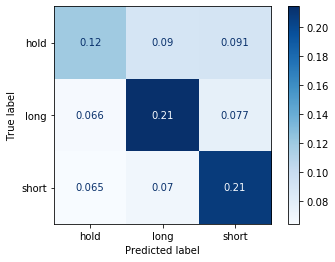

Error Score: 5.403755868544601
Confusion matrix:
 [[0.1200313  0.0900626  0.09068858]
 [0.06611894 0.2143975  0.07691706]
 [0.06455399 0.06971831 0.20751174]] 

-------------------------------------------


Sector is:  Real Estate
ZScorePredictor
Accuracy:  0.6565240499601381


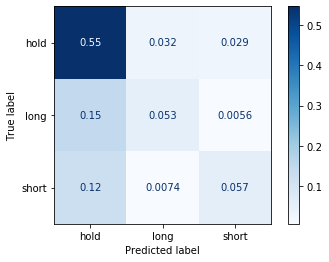

Error Score: 1.811387191070954
Confusion matrix:
 [[0.54683763 0.03202232 0.02949774]
 [0.1458278  0.05268403 0.00558065]
 [0.123173   0.00737444 0.05700239]] 

FiveDayPredictor
Accuracy:  0.600916821684826


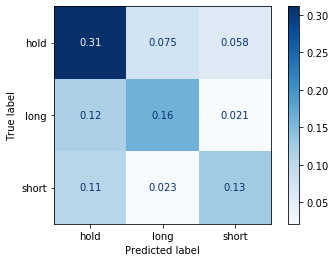

Error Score: 4.644233324475153
Confusion matrix:
 [[0.31125432 0.07513952 0.05779963]
 [0.11652936 0.16217114 0.02132607]
 [0.10516875 0.02311985 0.12749136]] 

-------------------------------------------


Sector is:  Financial Services
ZScorePredictor
Accuracy:  0.645043432327738


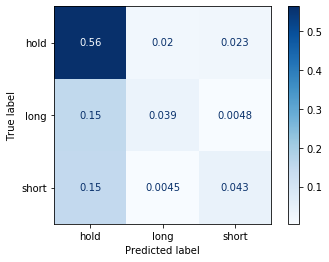

Error Score: 1.3699524592088272
Confusion matrix:
 [[0.56322632 0.02048362 0.02271393]
 [0.15287886 0.03883965 0.00484212]
 [0.14956274 0.00447529 0.04297746]] 

FiveDayPredictor
Accuracy:  0.6678747505575772


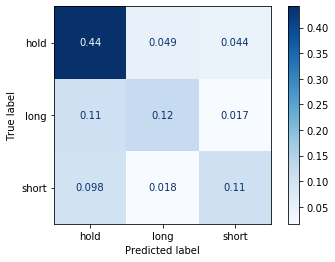

Error Score: 3.6770014086160345
Confusion matrix:
 [[0.4414544  0.04893473 0.04448879]
 [0.10555816 0.12127304 0.0166246 ]
 [0.0982363  0.01828266 0.10514732]] 

-------------------------------------------


Sector is:  Energy
ZScorePredictor
Accuracy:  0.596688421561518


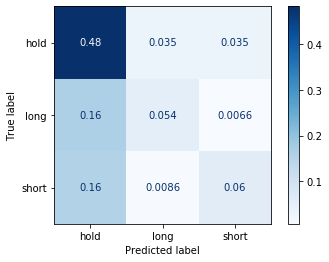

Error Score: 1.836173555716703
Confusion matrix:
 [[0.48307953 0.03486826 0.0353517 ]
 [0.16140923 0.05396423 0.00664733]
 [0.15645395 0.0085811  0.05964467]] 

FiveDayPredictor
Accuracy:  0.5851462412376118


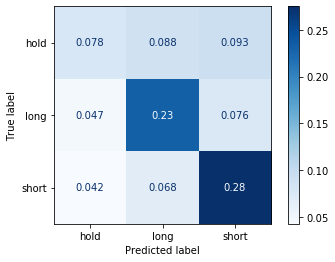

Error Score: 7.156453952139231
Confusion matrix:
 [[0.07789461 0.08816775 0.09270002]
 [0.04719604 0.23205221 0.07644428]
 [0.04242204 0.06792362 0.27519942]] 

-------------------------------------------


Sector is:  Consumer Defensive
ZScorePredictor
Accuracy:  0.5624404194470924


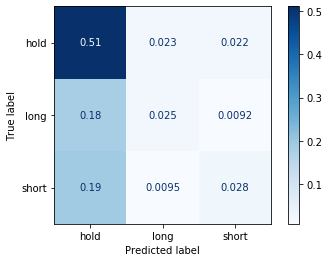

Error Score: 0.6086749285033365
Confusion matrix:
 [[0.51000953 0.0227836  0.02192564]
 [0.18236416 0.02478551 0.00915157]
 [0.19180172 0.00953289 0.02764538]] 

FiveDayPredictor
Accuracy:  0.5275500476644424


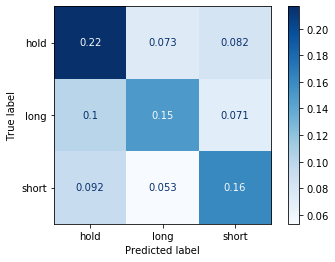

Error Score: 3.6367969494756913
Confusion matrix:
 [[0.21677788 0.07330791 0.08207817]
 [0.10114395 0.15014299 0.0706387 ]
 [0.09199237 0.05328885 0.16062917]] 

-------------------------------------------


Sector is:  Consumer Cyclical
ZScorePredictor
Accuracy:  0.5713190493483437


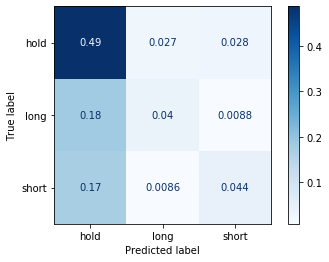

Error Score: 1.246620667392971
Confusion matrix:
 [[0.4869467  0.02719606 0.02840657]
 [0.18335149 0.04035024 0.00879635]
 [0.17233588 0.0085946  0.04402211]] 

FiveDayPredictor
Accuracy:  0.5410563692853972


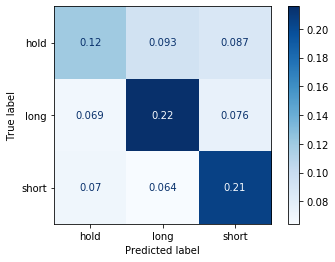

Error Score: 5.471694306581124
Confusion matrix:
 [[0.12028407 0.09296695 0.08719687]
 [0.06871646 0.21563168 0.07561635]
 [0.07000767 0.06443933 0.20514062]] 

-------------------------------------------


Sector is:  Utilities
ZScorePredictor
Accuracy:  0.6072783718523629


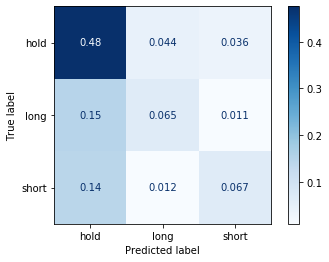

Error Score: 2.0317350810624353
Confusion matrix:
 [[0.4755088  0.04398068 0.03604691]
 [0.14729217 0.06502242 0.01052087]
 [0.14332528 0.01155571 0.06674715]] 

FiveDayPredictor
Accuracy:  0.5893411521214211


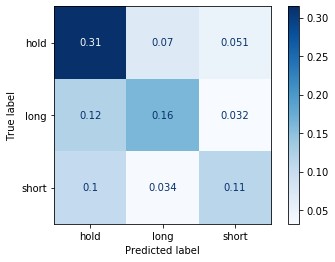

Error Score: 3.990169023801311
Confusion matrix:
 [[0.31459124 0.06950673 0.05087961]
 [0.11986892 0.16177992 0.0322525 ]
 [0.10400138 0.03414971 0.11296999]] 

-------------------------------------------


Sector is:  Technology
ZScorePredictor
Accuracy:  0.5732649505210902


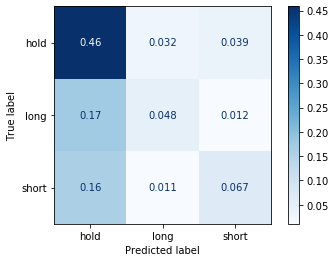

Error Score: 1.7426110398790151
Confusion matrix:
 [[0.45865799 0.03152842 0.03899135]
 [0.17365289 0.04799947 0.01160535]
 [0.16030509 0.01065194 0.06660749]] 

FiveDayPredictor
Accuracy:  0.5605089259295789


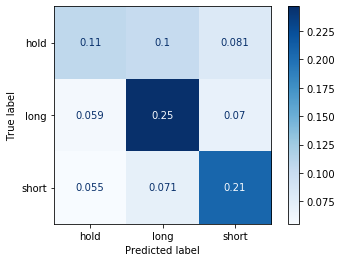

Error Score: 6.084919617319263
Confusion matrix:
 [[0.10711115 0.10277148 0.08120459]
 [0.05901305 0.24660552 0.069928  ]
 [0.0551994  0.07137456 0.20679225]] 

-------------------------------------------


Sector is:  Basic Materials
ZScorePredictor
Accuracy:  0.5489819439108721


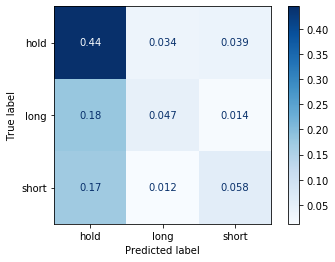

Error Score: 1.4533230887437572
Confusion matrix:
 [[0.44471763 0.03357664 0.03926239]
 [0.18040722 0.04663849 0.01398386]
 [0.17149443 0.01229351 0.05762582]] 

FiveDayPredictor
Accuracy:  0.577794852093738


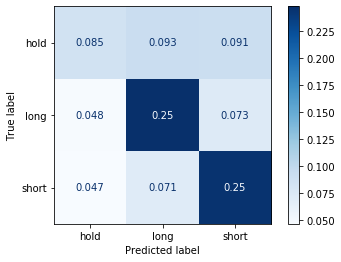

Error Score: 6.87322320399539
Confusion matrix:
 [[0.0848252  0.09258548 0.09097196]
 [0.04802151 0.24771418 0.07291587]
 [0.04671533 0.07099501 0.24525547]] 

-------------------------------------------


Sector is:  Financial
ZScorePredictor
Accuracy:  0.7090163934426229


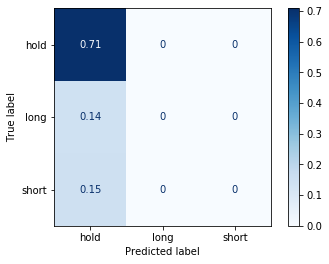

Error Score: 0.0
Confusion matrix:
 [[0.70901639 0.         0.        ]
 [0.14344262 0.         0.        ]
 [0.14754098 0.         0.        ]] 

FiveDayPredictor
Accuracy:  0.7336065573770492


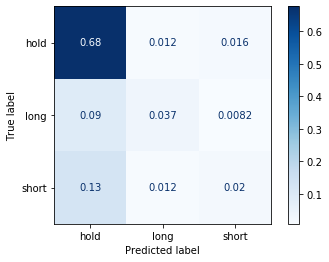

Error Score: 0.7377049180327869
Confusion matrix:
 [[0.67622951 0.01229508 0.01639344]
 [0.09016393 0.03688525 0.00819672]
 [0.12704918 0.01229508 0.0204918 ]] 

-------------------------------------------


Catboost accuracy:  0.5922483221551754
Catboost score:  3.1359206145974885
-------------------------------------------


Final Catboost accuracy:  0.5922483221551754
Final Catboost score:  3.1359206145974885


In [4]:
from catboost import CatBoostClassifier, Pool
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
basePath = 'data/smallFiltered-{}.csv'
colCount = 10000
secretColumns = ['zScoreOfChangeTmmrw','percentChangeInFiveDays', 'sector', 'tmmrwChngAsPerc']
countSinceLastIncreaseInScore = 0
droppedColumns = []
lastScore = 0
lastAccuracy = 0
while (countSinceLastIncreaseInScore < colCount):
    masterScore = []
    masterAccuracy = []
    masterFeatureDF = pd.DataFrame(data = {'featureName': [], 'importance': []})
    firstPass = True
    for x in range(5):
        combinedDF = pd.read_csv(basePath.format(x), parse_dates = True)
        combinedDF.drop(columns = ['Date'], inplace = True)
        if len(droppedColumns) != 0:
            combinedDF.drop(columns = droppedColumns, inplace = True)
        if firstPass:
            colCount = len(combinedDF.columns) - len(secretColumns)
            initDF = pd.DataFrame(data = {'featureName': combinedDF.columns, 'importance': [0] * len(combinedDF.columns)})
            masterFeatureDF.append(initDF)
            firstPass = False
        catLabels = ['ticker','industry']
        if x == 0:
            for col in combinedDF.columns:
                print(col)
        print('-------------------------------------------\n\n')
        sectorList = combinedDF['sector'].copy().unique()
        catAccuracy = []
        catError = []
        for sector in sectorList:
            print('Sector is: ', sector)
            sectorDF = combinedDF[combinedDF['sector'] == sector].copy()
            zScoreAnswer = sectorDF['zScoreOfChangeTmmrw']
            zScoreAnswer = zScoreAnswer.astype('float')
            zScoreAnswer = ['long' if x > .5 else 'short' if x < -.5 else 'hold' for x in zScoreAnswer ]
            fiveDayChangeAnswer = sectorDF['percentChangeInFiveDays']
            fiveDayChangeAnswer = ['long' if x > .015 else 'short' if x < -.015 else 'hold' for x in fiveDayChangeAnswer]
            tmmrwUpAnswer = sectorDF['tmmrwChngAsPerc']
            tmmrwUpAnswer = ['long' if x > 0 else 'short' for x in tmmrwUpAnswer]

            sectorDF.drop(columns = secretColumns, inplace = True)
            accuracy, error, featureDF = \
            catBoostMaker(sectorDF,zScoreAnswer,fiveDayChangeAnswer, tmmrwUpAnswer, sector, catLabels, x)
            catAccuracy.append(accuracy)
            catError.append(error)
            masterFeatureDF = masterFeatureDF + featureDF
            print('-------------------------------------------\n\n')
        print('Catboost accuracy: ', mean(catAccuracy))
        print('Catboost score: ' ,mean(catError))
        masterScore.append(mean(catError))
        masterAccuracy.append(mean(catAccuracy))
        
    print('-------------------------------------------\n\n')
    print('Final Catboost accuracy: ', mean(catAccuracy))
    print('Final Catboost score: ' ,mean(catError))
    print('Final Feature Importance:' masterFeatureDF)
    masterFeatureDF['features'] = masterFeatureDF.index
    
    featureToRemove = masterFeatureDF.get_value(masterFeatureDF['features'].min, 'features') 
    print(featureToRemove)
    break

In [9]:
from sklearn.ensemble import VotingClassifier
folderRoot = 'catPredictors/'
for name in ['ZScorePredictor','FiveDayPredictor','TmmrwUpPredictor']:
    for sector in ['Real_Estate', 'Basic_Materials', 'Healthcare', 'Consumer_Cyclical', 'Financial_Services',
            'Industrials', 'Technology', 'Communication_Services', 'Energy', 'Consumer_Defensive', 'Utilities', 'Financial']:
        models = [CatBoostClassifier().load_model('{}{}{}-{}.cbm'.format(folderRoot, name, sector, count)) for count in range(5)]
        vclf = VotingClassifier(estimators=[('catboost{}'.format(count), models[count]) for count in range(5)], voting='hard')
        pickle.dump(vclf, open('{}bagPredictor-{}-{}.pkl'.format(folderRoot, name, sector), 'wb'))